In this notebook we experiment with implementing Latent Credible Analysis models. Let's build the most simpleLCA

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

In [3]:
import seaborn as sns

In [4]:
import sys
sys.path.insert(0, '../')

import os.path as op

In [5]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import tensorflow_probability as tfp


from spectrum.preprocessing import encoders
from spectrum.judge import lca_tf, utils
from spectrum import evaluator

In [6]:
tf.__version__, tfp.__version__

('2.1.0', '0.9.0')

In [7]:
tf.random.set_seed(2020)

# Synthetic Dataset

In [8]:
DATA_DIR = '../data'
DATA_SET = 'population'

In [9]:
truths = pd.read_csv(op.join(DATA_DIR, DATA_SET, 'truths.csv'))
raw_claims = pd.read_csv(op.join(DATA_DIR, DATA_SET, 'claims.csv'))

We decide to model city population as discrete value. Moreover we consider the hidden truth value is only from the set of available assertions. Thus we need to label encode `value` of claims data frame.

### Data Preprocessing 

We need to label encode values of objects in order to feed them to our simpleLCA model

In [10]:
claims, le_dict = encoders.fit_and_transform(raw_claims) # this should be named fit and transform

# Truth Discovery

In [11]:
from spectrum.judge.lca_tf import LCA

In [12]:
lca = LCA()
trust, truth = lca.discover(claims, epochs=3, learning_rate=0.0005, report_every=1)

initialize...
number of sources:  636
number of objects:  293
initialize model parameters....
initialize guide parameters


../spectrum/inference/bbvi.py:71: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  log_p = ed.make_log_joint_fn(self.p)


iteration 0 -  loss 1451.501953125
iteration 1 -  loss 1427.403564453125
iteration 2 -  loss 1405.372802734375


Text(0, 0.5, 'loss')

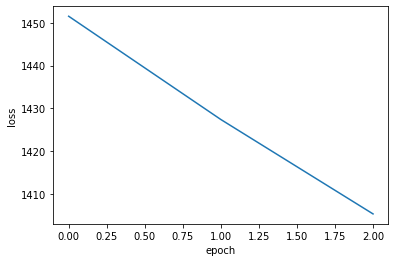

In [13]:
import matplotlib.pyplot as plt
plt.plot(lca.bbvi.train_loss, label='loss');
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.savefig('loss.pdf')

# Evaluation

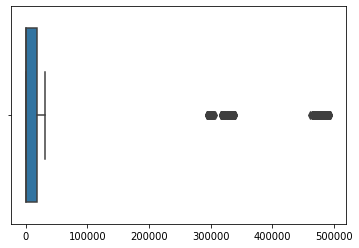

In [20]:
sns.boxplot(lca.bbvi.gradient_variance[0])

In [ ]:
sns.distplot(bbvi.gradient_variance[0])

In [ ]:
# from spectrum.inference.utils import flatten_gradients, compute_gradient_variance, compute_trust_and_truth

In [ ]:
# _, grads_and_vars = bbvi._bbvi_step()

In [ ]:
# flatten_gradients(grads_and_vars)

In [ ]:
# def compute_truth(q_z):
#     """compute truths
    
#     Parameters
#     ----------
#     q_z: callable
#         posterior distributions of hidden truth, z_truth_i
        
#     Returns
#     -------
#     z_truths: list
#         a list of hidden truth for each object, z_truths[i] is the 
#         inferred truth for object i.
#     """
#     with ed.tape() as q_z_sample:
#         q_z()
#     object_id = []
#     value = []
#     for z_name, z_sample in q_z_sample.items():
#         if z_name.startswith('z_truth'):
#             object_id.append(int(z_name.split('_')[2]))
#             value.append(z_sample.distribution.mode().numpy())
#     return pd.DataFrame(data={'object_id': object_id, 'value': value})

In [ ]:
discovered_truths = compute_truth(lca.mean_field_model)

# Evaluation 

We need to inverse transform the discovered truth value of each object into their original space.

In [ ]:
discovered_truths['value'] = discovered_truths.apply(lambda x: le_dict[x['object_id']].inverse_transform([x['value']])[0], axis=1)

In [ ]:
evaluator.accuracy(truths, discovered_truths)

The result is bad. This is expected if we look at the plot of loss values during training. They did not converge! The following can be reasons:
    1. Since SVI estimate gradients at each training step by performing sampling of `guide()`. The default number of is 1. We may increase the estimation accuracy by increasing the number of training.
    2. Our `guide()` model is just not good enough or `model()

In [ ]:
with ed.tape() as q_z_sample:
    lca.mean_field_model()

In [ ]:
def compute_incorrect_correct_objects(truths, discovered_truths):
    truth_df = truths.reindex(columns=['object_id', 'value']).set_index('object_id').sort_index()
    dis_truth_df = discovered_truths.reindex(columns=['object_id', 'value']).set_index('object_id').sort_index()
    
    incorrect_mask = truth_df['value'] != dis_truth_df['value']
    incorrect_objects = discovered_truths.index[incorrect_mask]
    incorrect_objects = [f'z_truth_{o}' for o in incorrect_objects]
    
    correct_objects = discovered_truths.index[~incorrect_mask]
    correct_objects = [f'z_truth_{o}' for o in correct_objects]
    
    return incorrect_objects, correct_objects

### Entropy plot

We plot incorrect entropy versus correct entropy distribution. The correct entropy represents the kind of entropy of the disibution of hidden truths. The lower entropy the better because the distribution are certain about its mode.

In [ ]:
incorrect_objects, correct_objects = compute_incorrect_correct_objects(truths, discovered_truths)

incorrect_entropies = [q_z_sample[o].distribution.entropy().numpy() for o in incorrect_objects]

correct_entropies = [q_z_sample[o].distribution.entropy().numpy() for o in correct_objects]

In [ ]:
sns.distplot(incorrect_entropies, label='incorrect entropy', hist=False)
sns.distplot(correct_entropies, label='correct entropy', hist=False)
plt.legend();
plt.savefig('object_entropy.pdf')

### Differnce plot

This is only valid for object whose dimension is 2

In [ ]:
def compute_prob_diff(objects):
    probs_diff = []
    for o in objects:
        probs = tf.exp(q_z_sample[o].distribution.parameters['logits']).numpy()
        if len(probs) == 2:
            probs_diff.append(np.abs(probs[0] - probs[1]))
    return probs_diff

In [ ]:
sns.distplot(compute_prob_diff(incorrect_objects))
sns.distplot(compute_prob_diff(correct_objects))